In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pearsonr

from helpers.nationality import *

# Initial analysis: How does nationality relate to Oscar nominations?

In [35]:
movie_df = pd.read_csv('cache/data.csv', sep=',', index_col=0)

In [49]:
movie_df

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,actor_age,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes
0,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,M,1.727,/m/0x67,32,ice cube,/m/01vw26l,ghosts of mars_2001_ice cube,NaN,NaN,False,2001,4.9,58876
4,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.780,/m/044038p,27,natasha henstridge,/m/0346l4,ghosts of mars_2001_natasha henstridge,NaN,NaN,False,2001,4.9,58876
11,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.727,/m/0x67,52,pam grier,/m/0418ft,ghosts of mars_2001_pam grier,NaN,NaN,False,2001,4.9,58876
51,Alexander's Ragtime Band,3600000,106,['English Language'],['United States of America'],"['Musical', 'Comedy']",alexanders ragtime band_1938,M,1.820,/m/06v41q,24,tyrone power,/m/02s58t,alexanders ragtime band_1938_tyrone power,NaN,NaN,False,1938,6.8,2357
52,Alexander's Ragtime Band,3600000,106,['English Language'],['United States of America'],"['Musical', 'Comedy']",alexanders ragtime band_1938,F,1.650,/m/033tf_,23,alice faye,/m/032xfz,alexanders ragtime band_1938_alice faye,NaN,NaN,False,1938,6.8,2357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443407,State and Main,6944471,106,"['Italian Language', 'English Language']","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",state and main_2000,M,1.770,/m/033tf_,33,philip seymour hoffman,/m/02qgqt,state and main_2000_philip seymour hoffman,NaN,NaN,False,2000,6.7,22784
443408,State and Main,6944471,106,"['Italian Language', 'English Language']","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",state and main_2000,M,1.700,/m/041rx,45,david paymer,/m/02t_vx,state and main_2000_david paymer,NaN,NaN,False,2000,6.7,22784
443414,State and Main,6944471,106,"['Italian Language', 'English Language']","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",state and main_2000,M,1.910,/m/022dp5,20,john krasinski,/m/060j8b,state and main_2000_john krasinski,NaN,NaN,False,2000,6.7,22784
443423,State and Main,6944471,106,"['Italian Language', 'English Language']","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",state and main_2000,F,1.600,/m/041rx,35,sarah jessica parker,/m/0m66w,state and main_2000_sarah jessica parker,NaN,NaN,False,2000,6.7,22784


We plot the 10 countries with the most Oscar nominations:

In [36]:
# Getting dataframes of all nominated movies with the "countries"-column exploded (meaning we have one row per actor/movie/country combination)
# exploded_df contains all rows in the dataset exploded by country, nominated_df contains all rows from exploded_df that were nominated for an Oscar
nominated_df, exploded_df = get_nationality_dfs(movie_df)

Number of rows, including those with multiple nationalities: 23819


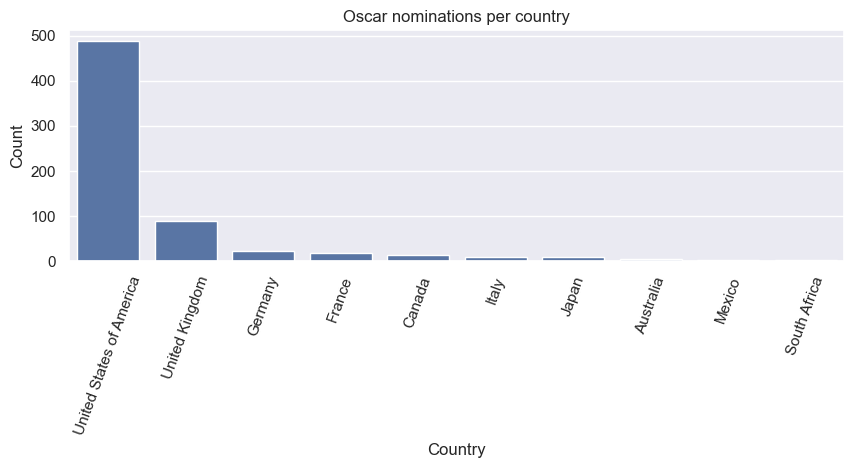

In [37]:
sns.set_theme(rc={'figure.figsize':(10, 3)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=nominated_df, order=nominated_df['country'].value_counts()[:10].index);
plt.savefig('plots/oscar-nom-per-country.png', bbox_inches='tight')

We see that the USA is vastly overrepresented. We combine all countries other than the USA and UK into an "others" category

In [50]:
others_df = nominated_df.copy()
others_df['country'] = others_df['country'].apply(lambda country: country if country in ['United States of America', 'United Kingdom'] else 'Others')

# We drop duplicates to ensure that the same movie won't be counted multiple times for Others
others_df = others_df.drop_duplicates(subset=['country', 'identifier'])

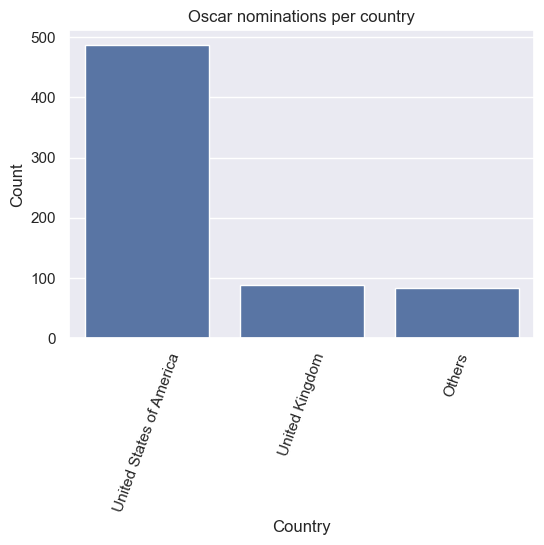

In [51]:
sns.set_theme(rc={'figure.figsize':(6, 4)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=others_df, order=others_df['country'].value_counts()[:10].index);

In [40]:
# Get series of countries with their number of nominations adjusted for total number of rows in the dataset. Gives us some idea of the probability of a row from a country being nominated
adjusted_nominations = get_adjusted_nominations(exploded_df, nominated_df)

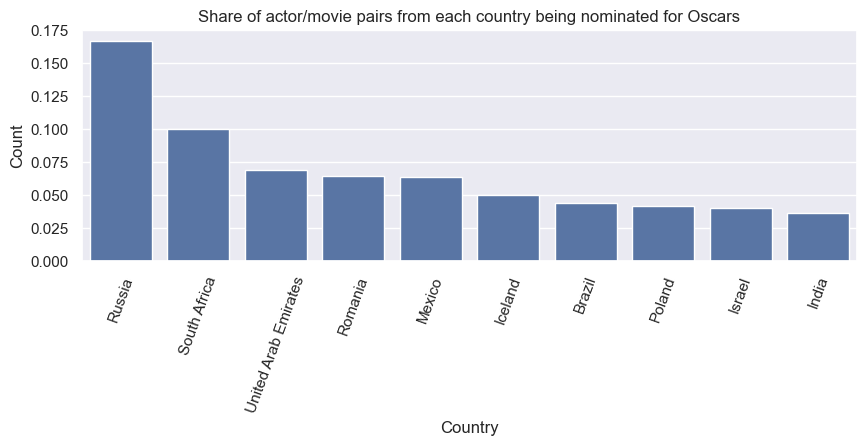

In [41]:
sns.set_theme(rc={'figure.figsize':(10, 3)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Share of actor/movie pairs from each country being nominated for Oscars')
# Make a barplot for the top 10 countries after adjustment
sns.barplot(data = adjusted_nominations.sort_values(ascending=False)[:10]);
plt.savefig('plots/oscar-nom-per-country-adjusted.png', bbox_inches='tight')

Russia is a surprising winner, could it be an outlier?

In [42]:
Russia_nominees = exploded_df[(exploded_df['country'] == 'Russia') & (exploded_df['oscar_nominated'] == True)]
print(f"Number of russian nominations: {len(Russia_nominees)}")
Russia_nominees

Number of russian nominations: 2


,index,title,box_office_revenue,runtime,languages,country,genres,movie_identifier,actor_gender,actor_height,...,actor_age,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes
16612,220076,The Last Station,10332256,113,['English Language'],Russia,"['Biography', 'World cinema', 'History', ', ',...",the last station_2009,F,1.630,...,64,helen mirren,/m/01hkhq,the last station_2009_helen mirren,ACTRESS IN A LEADING ROLE,False,True,2009,6.9,19290
16615,220078,The Last Station,10332256,113,['English Language'],Russia,"['Biography', 'World cinema', 'History', ', ',...",the last station_2009,M,1.778,...,79,christopher plummer,/m/01ycbq,the last station_2009_christopher plummer,ACTOR IN A SUPPORTING ROLE,False,True,2009,6.9,19290


We see that the Russian nominations are for only one film. This makes Russia a clear outlier.

In general, this analysis is very affected by our data cleaning process. For example, as documented in the data pipeline, we drop most actor/movie rows from India (Which means that we basically disregard Bollywood in this analysis, even though Bollywood would very likely have introduced a significant shift in the Oscard nomination probabilities). Keeping this in mind, we move on to analyze the distribution of American vs. non-American movies in our dataset.

# Binomial analysis USA vs. non-USA

In [43]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(movie_df['countries'])
american_total_actors_num = len(movie_df[movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(movie_df[movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(movie_df[(movie_df['countries'].str.contains('United States of America')) & (movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [44]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

BinomTestResult(k=32, n=1644, alternative='two-sided', statistic=0.019464720194647202, pvalue=0.555551516013016)

Using alpha=0.05. P-value=0.56 > 0.05. The conclusion from this is that surprisingly, American movies in our dataset do not have a significantly different probability of being nominated for Oscars. Again, this is likely due to our data cleaning, where we remove for example a lot of Indian rows that had NaN-values (And were also likely not Oscar nominated).

In [45]:
print('Fraction of American actors nominated for an Oscar:',round(p_american, 5))
print('Fraction of non-American actors nominated for an Oscar:', round(p_non_american, 5))

Fraction of American actors nominated for an Oscar: 0.02196
Fraction of non-American actors nominated for an Oscar: 0.01946


While the probability of winning an Oscar in general is likely higher for American movies, we will keep the non-American movies in this dataset, as the cleaning seems to have removed the expected multicolinearity between country and Oscar nomination.

# Analysis on data before our cleaning

While the nationality analysis does not affect how we treat our dataset moving forward, it is also interesting to examine how nationality relates to chances of Oscar nomination before we remove null-values (that is, how does it relate to the whole combined dataset). We perform the same binomial analysis on the uncleaned data.

In [46]:
uncleaned_movie_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [47]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(uncleaned_movie_df['countries'])
american_total_actors_num = len(uncleaned_movie_df[uncleaned_movie_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(uncleaned_movie_df[uncleaned_movie_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(uncleaned_movie_df[(uncleaned_movie_df['countries'].str.contains('United States of America')) & (uncleaned_movie_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [48]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

print(f"Share of American movies being nominated: {p_american}")
print(f"Share of non-American movies being nominated: {p_non_american}")

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

Share of American movies being nominated: 0.005462821195579816
Share of non-American movies being nominated: 0.0006399149405371347


BinomTestResult(k=130, n=203152, alternative='two-sided', statistic=0.0006399149405371347, pvalue=2.6118071094409342e-307)

Using alpha=0.05, this p-value is far below our alpha. This indicates a significantly different distribution.

We see that the same test performed on the full dataset before dropping null-values shows a significantly higher chance for American movies to be nominated than non-American movies. Assuming that the complete dataset is representative of the real world, we conclude that actors in American movies in general have a much higher chance of being nominated for an Oscar compared to actors in non-American movies.